## Pre-Requisites

Import dependencies

In [40]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import cv2
import pickle
from dahuffman import HuffmanCodec

<font color='green'>Set Factors here!</font>

In [41]:
# Values should be between 0.1 and 1. The higher the value, the higher the compression. If it exceeds 1, heavy artifacting will happen. (Quantization Factor)
QP = 0.3

# Divides the U and V channels resolution by this factor. Higher value, means more downsampling (Downsampling Factor)
downsampling_factor = 3

# Quantization Matrix
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

Define some helper functions for image displaying

In [42]:
# Helper function to show a single image in a plot
def show_image(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

# Helper function to show two images side by side in a plot
def show_image_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')
    plt.show()

---

## Compressing the image

Read in the image and convert it to YCbCr

In [43]:
# Read in test image from assets/test.png and convert to YCbCr
img = Image.open('assets/test.png')
img_shape = img.size

# Convert the image to YCbCr
img_yuv = img.convert('YCbCr')

# Extract Y, Cb, and Cr channels
y, cb, cr = cv2.split(np.array(img_yuv))

Downsample the chroma channels by the factor 'downsampling_factor' defined before

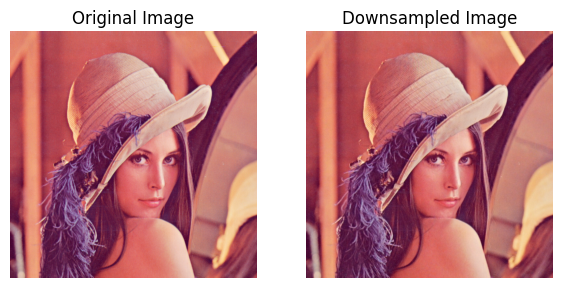

In [44]:
# Downsample Cb and Cr channels
cb_downsampled = cv2.resize(cb, (cb.shape[1] // downsampling_factor, cb.shape[0] // downsampling_factor),
                            interpolation=cv2.INTER_LINEAR)
cr_downsampled = cv2.resize(cr, (cr.shape[1] // downsampling_factor, cr.shape[0] // downsampling_factor),
                            interpolation=cv2.INTER_LINEAR)

# Ensure the downsampled Cb and Cr channels have the same size as the original channels
cb_downsampled = cv2.resize(cb_downsampled, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)
cr_downsampled = cv2.resize(cr_downsampled, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)

# Merge the downsampled Cb and Cr channels with the original Y channel
downsampled_yuv = cv2.merge([y, cb_downsampled, cr_downsampled])

# Convert back to PIL Image
downsampled_img = Image.fromarray(downsampled_yuv, mode='YCbCr')

# Show the original and downsampled images side by side
show_image_side_by_side(img, downsampled_img, 'Original Image', 'Downsampled Image')

Split each channel into a 0-padded 8x8 pixel block and center each pixel value around 0 (by subtracting 128)

In [45]:
def split_and_center(channel):
    h, w = channel.shape
    # Calculate padding needed for both dimensions
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8

    # Pad the image
    padded_channel = np.pad(channel, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

    # Split the padded image into 8x8 pixel chunks
    blocks = [padded_channel[i:i+8, j:j+8] for i in range(0, padded_channel.shape[0], 8) for j in range(0, padded_channel.shape[1], 8)]

    # Center values around 0 by subtracting 128 from every pixel value
    centered_blocks = [np.int8(block - 128) for block in blocks]

    return centered_blocks

# Extract Y, Cb, and Cr channels
y, cb, cr = cv2.split(np.array(downsampled_img))

# Apply the block splitting and centering function to each channel
y_blocks_centered = split_and_center(y)
cb_blocks_centered = split_and_center(cb)
cr_blocks_centered = split_and_center(cr)


Apply DCT to each block

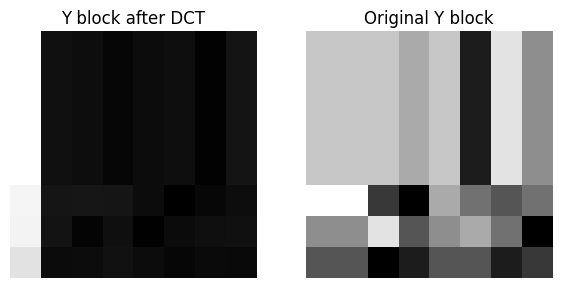

In [46]:
y_blocks_dct = [dct(block, norm='ortho') for block in y_blocks_centered]
cb_blocks_dct = [dct(block, norm='ortho') for block in cb_blocks_centered]
cr_blocks_dct = [dct(block, norm='ortho') for block in cr_blocks_centered]

# Display the first block of the Y channel channel and the original block
show_image_side_by_side(y_blocks_dct[0], y_blocks_centered[0], 'Y block after DCT', 'Original Y block')

Apply Quantization to all DCT Coefficients

In [47]:
# Calculate the quantization matrix based on the given factor QP
quantization_matrix = np.round(Q * QP)

y_blocks_quantized = [np.round(block / quantization_matrix) for block in y_blocks_dct]
cb_blocks_quantized = [np.round(block / quantization_matrix) for block in cb_blocks_dct]
cr_blocks_quantized = [np.round(block / quantization_matrix) for block in cr_blocks_dct]

Perform huffman encoding on all blocks

In [48]:
# Flatten and serialize the quantized blocks
def flatten_and_serialize(blocks):
    flattened_blocks = [block.flatten().tolist() for block in blocks]
    return pickle.dumps(flattened_blocks)

# Huffman encode the serialized data
def huffman_encode(serialized_data):
    codec = HuffmanCodec.from_data(serialized_data)
    encoded_data = codec.encode(serialized_data)
    return encoded_data, codec

# Extract quantized blocks from each channel
y_quantized_data = flatten_and_serialize(y_blocks_quantized)
cb_quantized_data = flatten_and_serialize(cb_blocks_quantized)
cr_quantized_data = flatten_and_serialize(cr_blocks_quantized)

# Huffman encode the quantized data
y_encoded_data, y_huffman_codec = huffman_encode(y_quantized_data)
cb_encoded_data, cb_huffman_codec = huffman_encode(cb_quantized_data)
cr_encoded_data, cr_huffman_codec = huffman_encode(cr_quantized_data)


Put everything needed into the metadata and write it in a file 'test.bin'

In [49]:
# Serialize Huffman codecs to make them part of the metadata
y_codec_serialized = pickle.dumps(y_huffman_codec)
cb_codec_serialized = pickle.dumps(cb_huffman_codec)
cr_codec_serialized = pickle.dumps(cr_huffman_codec)

# Updated metadata dictionary to include codecs
metadata = {
    "shape": img_shape,  # Original image shape (height, width)
    "Q": Q.tolist(),     # Quantization matrix
    "QP": QP,            # Quantization factor
    "y_codec": y_codec_serialized,
    "cb_codec": cb_codec_serialized,
    "cr_codec": cr_codec_serialized
}

# Serialize the entire metadata
serialized_metadata = pickle.dumps(metadata)

# Combine encoded data with metadata
combined_data = {
    "metadata": serialized_metadata,
    "y_data": y_encoded_data,
    "cb_data": cb_encoded_data,
    "cr_data": cr_encoded_data
}

# Serialize the combined data
serialized_combined_data = pickle.dumps(combined_data)

# Write combined data to file
with open("output/test.bin", "wb") as f:
    f.write(serialized_combined_data)